In [214]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd

In [215]:
n_samples = 1000

In [216]:
X, Y = make_circles(n_samples, noise=0.01, random_state=42)

In [217]:
X[:5], Y[:5]

(array([[ 0.76628562,  0.21627572],
        [-0.77828546,  0.13782611],
        [-0.80092515,  0.12460507],
        [-0.35832587,  0.71353535],
        [ 0.43881306, -0.89851131]]),
 array([1, 1, 1, 1, 0]))

In [218]:
circle = pd.DataFrame({"X1": X[:, 0], "X2":X[:, 1], "Lables": Y})

In [219]:
circle.head()

,X1,X2,Lables
0,0.766286,0.216276,1
1,-0.778285,0.137826,1
2,-0.800925,0.124605,1
3,-0.358326,0.713535,1
4,0.438813,-0.898511,0


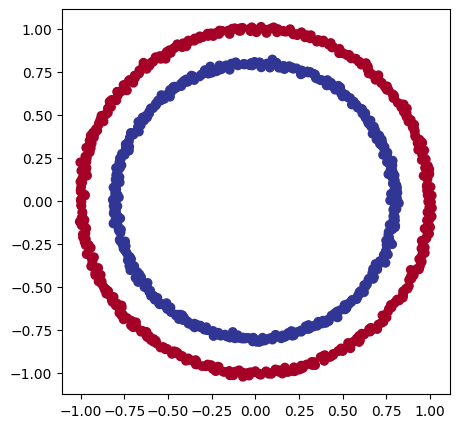

In [220]:
plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, cmap=plt.cm.RdYlBu   )

In [221]:
X.shape, Y.shape

((1000, 2), (1000,))

In [222]:
X_sample = X[0]
Y_sample = Y[0]

In [223]:
X_sample, X_sample.shape, Y_sample, Y_sample.shape

(array([0.76628562, 0.21627572]), (2,), np.int64(1), ())

In [224]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [225]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42, stratify=Y)

In [226]:
X.shape, X_train.shape, X_test.shape

(torch.Size([1000, 2]), torch.Size([800, 2]), torch.Size([200, 2]))

### Build a model to classify our blue and red dots.


In [227]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 5)
        self.layer2 = nn.Linear(5, 1)

        # self.two_line_layers = nn.Sequential(
        #     nn.Linear(2, 5),
        #     nn.Linear(5, 1),
        # )
    
    def forward(self, x):
        # return self.two_line_layers(x)
        return self.layer2(self.layer1(x))


In [228]:
model_0 = CircleModelV1()

In [229]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer2.bias', tensor([-0.2060]))])

`nn.Sequential()` is a container module in PyTorch that lets you stack layers or operations in order — it builds a model by running data through each layer sequentially.


In [230]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
)

In [231]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

#### Make rpedictions


In [232]:
torch.inference_mode()
untrained_pred = model_0(X_test)

untrained_pred.shape, untrained_pred[:10]

(torch.Size([200, 1]),
 tensor([[ 0.1504],
         [ 0.2394],
         [ 0.2746],
         [ 0.1064],
         [-0.0381],
         [ 0.1044],
         [ 0.2423],
         [ 0.0019],
         [-0.0569],
         [ 0.3307]], grad_fn=<SliceBackward0>))

### set up loss fun and optimizer


In [233]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [234]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [235]:
with torch.inference_mode():
    y_logits = model_0(X_test)

y_logits[:5]

tensor([[ 0.1504],
        [ 0.2394],
        [ 0.2746],
        [ 0.1064],
        [-0.0381]])

In [236]:
y_pred_probs = torch.sigmoid(y_logits)

y_pred_probs[:5]

tensor([[0.5375],
        [0.5596],
        [0.5682],
        [0.5266],
        [0.4905]])

In [237]:
torch.round(y_pred_probs)[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]])

In [238]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)))

y_pred_labels.squeeze()[:5]

tensor([1., 1., 1., 1., 0.], grad_fn=<SliceBackward0>)

In [239]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_0.train()

    y_pred = model_0(X_train)

    loss = loss_fn(y_pred, Y_train.unsqueeze(1))

    acc = accuracy_fn(y_true=Y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            Y_test)
        test_acc = accuracy_fn(y_true=Y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69651, Accuracy: 0.00% | Test loss: 0.69998, Test acc: 52.00%
Epoch: 10 | Loss: 0.69482, Accuracy: 0.00% | Test loss: 0.69804, Test acc: 52.50%
Epoch: 20 | Loss: 0.69408, Accuracy: 0.00% | Test loss: 0.69701, Test acc: 50.50%
Epoch: 30 | Loss: 0.69371, Accuracy: 0.00% | Test loss: 0.69636, Test acc: 50.00%
Epoch: 40 | Loss: 0.69350, Accuracy: 0.00% | Test loss: 0.69590, Test acc: 49.50%
Epoch: 50 | Loss: 0.69337, Accuracy: 0.00% | Test loss: 0.69555, Test acc: 48.00%
Epoch: 60 | Loss: 0.69328, Accuracy: 0.00% | Test loss: 0.69528, Test acc: 48.00%
Epoch: 70 | Loss: 0.69322, Accuracy: 0.00% | Test loss: 0.69506, Test acc: 47.00%
Epoch: 80 | Loss: 0.69318, Accuracy: 0.00% | Test loss: 0.69488, Test acc: 48.00%
Epoch: 90 | Loss: 0.69315, Accuracy: 0.00% | Test loss: 0.69474, Test acc: 48.50%


In [240]:
with torch.inference_mode():
    y_pred = model_0(X_test)

KeyError: 'Labels'